In [1]:
#从已有模型finetuning
# config=[
#     "--logdir", "./runs/model_test/main_model",
#     "--model_suffix", "free",
# ]
import os
os.environ['ON_PY']="1"

from params import parser

from model.PPO import PPO
from train.base import *
import numpy.ma as ma

(CVXPY) Mar 14 04:17:55 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 14 04:17:55 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/wlc/miniconda3/envs/RL-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:

class PPOT(PPO):
    def __init__(self, config):
        super().__init__(config)


    def update(self, memory, freeze_feature_exact = False):
        '''
        :param memory: data used for PPO training
        :return: total_loss and critic_loss
        '''

        # 获取转置后的训练数据，用于策略更新
        t_data = memory.transpose_data()  # Tensor len 13  pre torch.Size([1000, 50, 10])
        # 计算广义优势估计（GAE）和目标价值  A_t, G_t
        t_advantage_seq, v_target_seq = memory.get_gae_advantages()

        full_batch_size = len(t_data[-1])  # 获取完整批次大小 # 1000
        num_batch = np.ceil(full_batch_size / self.minibatch_size)  # 计算小批次数 1.0

        loss_epochs = 0
        v_loss_epochs = 0
        if freeze_feature_exact:
            for name, param in self.policy.named_parameters():
                if name.startswith('feature_exact'):
                    param.requires_grad = False

        for _ in range(self.k_epochs):  # 4
            # 对每个迭代进行小批次的策略更新
            # Split into multiple batches of updates due to memory limitations
            
            for i in range(int(num_batch)):
                if i + 1 < num_batch:
                    start_idx = i * self.minibatch_size
                    end_idx = (i + 1) * self.minibatch_size
                else:
                    # the last batch  处理最后一个小批次
                    start_idx = i * self.minibatch_size
                    end_idx = full_batch_size

                # 通过策略网络获取动作分布和值函数估计
                pis, vals = self.policy(fea_j=t_data[0][start_idx:end_idx],
                                        op_mask=t_data[1][start_idx:end_idx],
                                        candidate=t_data[6][start_idx:end_idx],
                                        fea_m=t_data[2][start_idx:end_idx],
                                        mch_mask=t_data[3][start_idx:end_idx],
                                        comp_idx=t_data[5][start_idx:end_idx],
                                        dynamic_pair_mask=t_data[4][start_idx:end_idx],
                                        fea_pairs=t_data[7][start_idx:end_idx])

                action_batch = t_data[8][start_idx: end_idx]  # 获取动作序列
                logprobs, ent_loss = eval_actions(pis, action_batch)  # 计算动作的概率和熵损失
                ratios = torch.exp(logprobs - t_data[12][start_idx: end_idx].detach())  # 计算重要性采样比率

                advantages = t_advantage_seq[start_idx: end_idx]  # 获取优势估计
                surr1 = ratios * advantages  # 计算第一个损失项
                surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages  # 计算第二个损失项

                v_loss = self.V_loss_2(vals.squeeze(1), v_target_seq[start_idx: end_idx])  # 计算价值损失
                p_loss = - torch.min(surr1, surr2)  # 计算策略损失   L^PPO-clip(pi_theta)
                ent_loss = - ent_loss.clone()  # 计算熵损失
                loss = self.vloss_coef * v_loss + self.ploss_coef * p_loss + self.entloss_coef * ent_loss  # 计算总损失
                # 梯度清零，进行反向传播和优化
                self.optimizer.zero_grad()  
                loss_epochs += loss.mean().detach()
                v_loss_epochs += v_loss.mean().detach()
                loss.mean().backward()
                # # 查看哪些参数受到loss的影响
                # for name, param in self.policy.named_parameters():
                #     if param.grad is not None and torch.sum(torch.abs(param.grad)) > 0:
                #         print(name, "受到了loss的影响")
                #     else:
                #         print(name, "没有受到loss的影响")
                self.optimizer.step()
        # soft update 进行软更新
        for policy_old_params, policy_params in zip(self.policy_old.parameters(), self.policy.parameters()):
            policy_old_params.data.copy_(self.tau * policy_old_params.data + (1 - self.tau) * policy_params.data)

        return loss_epochs.item() / self.k_epochs, v_loss_epochs.item() / self.k_epochs


In [3]:

def PPO_initialize():
    ppo = PPOT(configs)
    
    # writer = SummaryWriter(log_dir=configs.logdir, flush_secs=180)

    # writer.add_graph(dict(ppo.policy.named_parameters()))
    # writer.close()
    return ppo


In [4]:
from fjsp_env_same_op_nums import FJSPEnvForSameOpNums

class FJSPEnvForSameOpNums_test(FJSPEnvForSameOpNums):
    def __init__(self, n_j, n_m):
        super().__init__(n_j, n_m)
    
    # def step(self, actions):
    #     """
    #         perform the state transition & return the next state and reward
    #     :param actions: the action list with shape [E]
    #     :return: the next state, reward and the done flag
    #     """
    #     print(actions)
    #     super().step(actions)
    
    def step(self, actions):
        """
            perform the state transition & return the next state and reward
        :param actions: the action list with shape [E]
        :return: the next state, reward and the done flag
        """
        # actions = [1, 6]
        chosen_job = actions // self.number_of_machines   # [0, 2] 选择的工件id，
        chosen_mch = actions % self.number_of_machines    # [1, 0] 选择的机器id
        #self.candidate=array([[ 0,  3,  6,  9, 12], 
        ##                     [ 0,  3,  6,  9, 12]])
        chosen_op = self.candidate[self.env_idxs, chosen_job]  #行 列   -> [0, 6]

        if (self.reverse_process_relation[self.env_idxs, chosen_op, chosen_mch]).any():
            print(
                f'FJSP_Env.py Error from choosing action: Op {chosen_op} can\'t be processed by Mch {chosen_mch}')
            sys.exit()

        self.step_count += 1

        # update candidate  如果工件被加工，那么candidate对应位置的值要+1
        candidate_add_flag = (chosen_op != self.job_last_op_id[self.env_idxs, chosen_job])# [True, True]
        self.candidate[self.env_idxs, chosen_job] += candidate_add_flag
        # 这步以后candidate： array([[ 1,  3,  6,  9, 12], [ 0,  3,  7,  9, 12]])
        self.mask[self.env_idxs, chosen_job] = (1 - candidate_add_flag)
        #array([[False, False, False, False, False],
        #       [False, False, False, False, False]])
        # the start processing time of chosen operations
        '''self.candidate_free_time: array([[0., 0., 0., 0., 0.], [0., 0., 0., 0., 0.]])
        self.mch_free_time: array([[0., 0., 0.], [0., 0., 0.]])
        '''
        chosen_op_st = np.maximum(self.candidate_free_time[self.env_idxs, chosen_job],
                                  self.mch_free_time[self.env_idxs, chosen_mch]) # 选择操作的开始时间
        '''self.op_ct: array([[0.74747475, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.15151515, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])'''
        self.op_ct[self.env_idxs, chosen_op] = chosen_op_st + self.op_pt[
            self.env_idxs, chosen_op, chosen_mch]  # 更新操作的结束时间
        self.candidate_free_time[self.env_idxs, chosen_job] = self.op_ct[self.env_idxs, chosen_op]
        self.mch_free_time[self.env_idxs, chosen_mch] = self.op_ct[self.env_idxs, chosen_op]
        '''self.mch_free_time: array([[0.74747475, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.15151515, 0.        , 0.        ]])'''
        
        true_chosen_op_st = np.maximum(self.true_candidate_free_time[self.env_idxs, chosen_job],
                                       self.true_mch_free_time[self.env_idxs, chosen_mch])## [0, 0]
        self.true_op_ct[self.env_idxs, chosen_op] = true_chosen_op_st + self.true_op_pt[
            self.env_idxs, chosen_op, chosen_mch]
        '''
        array([[74.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 15.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.]])
        '''
        self.true_candidate_free_time[self.env_idxs, chosen_job] = self.true_op_ct[
            self.env_idxs, chosen_op]
        '''array([[74.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 15.,  0.,  0.]])'''
        self.true_mch_free_time[self.env_idxs, chosen_mch] = self.true_op_ct[
            self.env_idxs, chosen_op]
        '''array([[ 0., 74.,  0.],
       [15.,  0.,  0.]])'''
        self.current_makespan = np.maximum(self.current_makespan, self.true_op_ct[
            self.env_idxs, chosen_op]) # array([74., 15.])

        # update the candidate message
        mask_temp = candidate_add_flag # [True, True]
        self.candidate_pt[mask_temp, chosen_job[mask_temp]] = self.unmasked_op_pt[mask_temp, chosen_op[mask_temp] + 1]
        '''
        array([[[0.47474747, 0.97979798, 0.        ],
        [0.97979798, 0.81818182, 0.6969697 ],
        [0.67676768, 0.85858586, 0.48484848],
        [0.86868687, 0.        , 0.28282828],
        [0.65656566, 0.        , 0.        ]],

       [[0.49494949, 0.        , 0.92929293],
        [0.90909091, 1.        , 0.        ],
        [0.13131313, 0.55555556, 0.        ],
        [0.75757576, 0.66666667, 0.48484848],
        [0.41414141, 0.        , 0.        ]]])
        '''
        self.candidate_process_relation[mask_temp, chosen_job[mask_temp]] = \
            self.reverse_process_relation[mask_temp, chosen_op[mask_temp] + 1]
        '''array([[[False, False,  True],
        [False, False, False],
        [False, False, False],
        [False,  True, False],
        [False,  True,  True]],

       [[False,  True, False],
        [False, False,  True],
        [False, False,  True],
        [False, False, False],
        [False,  True,  True]]])'''
        self.candidate_process_relation[~mask_temp, chosen_job[~mask_temp]] = 1
        '''array([[[False, False,  True],
        [False, False, False],
        [False, False, False],
        [False,  True, False],
        [False,  True,  True]],

       [[False,  True, False],
        [False, False,  True],
        [False, False,  True],
        [False, False, False],
        [False,  True,  True]]])'''
        # compute the next schedule time

        # [E, J, M]
        candidateFT_for_compare = np.expand_dims(self.candidate_free_time, axis=2)
        '''array([[[0.74747475],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.15151515],
        [0.        ],
        [0.        ]]])'''
        mchFT_for_compare = np.expand_dims(self.mch_free_time, axis=1)
        '''array([[[0.        , 0.74747475, 0.        ]],
       [[0.15151515, 0.        , 0.        ]]])'''
        self.pair_free_time = np.maximum(candidateFT_for_compare, mchFT_for_compare)
        '''array([[[0.74747475, 0.74747475, 0.74747475],
        [0.        , 0.74747475, 0.        ],
        [0.        , 0.74747475, 0.        ],
        [0.        , 0.74747475, 0.        ],
        [0.        , 0.74747475, 0.        ]],

       [[0.15151515, 0.        , 0.        ],
        [0.15151515, 0.        , 0.        ],
        [0.15151515, 0.15151515, 0.15151515],
        [0.15151515, 0.        , 0.        ],
        [0.15151515, 0.        , 0.        ]]])'''
        schedule_matrix = ma.array(self.pair_free_time, mask=self.candidate_process_relation)
        '''masked_array(
  data=[[[0.747474747399245, 0.747474747399245, --],
         [0.0, 0.747474747399245, 0.0],
         [0.0, 0.747474747399245, 0.0],
         [0.0, --, 0.0],
         [0.0, --, --]],

        [[0.15151515149984696, --, 0.0],
         [0.15151515149984696, 0.0, --],
         [0.15151515149984696, 0.15151515149984696, --],
         [0.15151515149984696, 0.0, 0.0],
         [0.15151515149984696, --, --]]],'''
        self.next_schedule_time = np.min(
            schedule_matrix.reshape(self.number_of_envs, -1), axis=1).data # array([0., 0.])

        self.remain_process_relation[self.env_idxs, chosen_op] = 0
        '''array([[[False, False, False],
                ...
        [ True,  True,  True]],
       [[ True, False,  True],
                    ...
        [ True,  True, False]]])'''
        self.op_scheduled_flag[self.env_idxs, chosen_op] = 1
        '''array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])'''
        """
            update the mask for deleting nodes
        """
        self.deleted_op_nodes = \
            np.logical_and((self.op_ct <= self.next_schedule_time[:, np.newaxis]),
                           self.op_scheduled_flag)
        '''array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]])'''
        self.delete_mask_fea_j = np.tile(self.deleted_op_nodes[:, :, np.newaxis],
                                         (1, 1, self.op_fea_dim))
        '''False * (2, 15, 10)'''

        """
            update the state
        """
        self.update_op_mask()

        # update operation raw features
        diff = self.op_ct[self.env_idxs, chosen_op] - self.op_ct_lb[self.env_idxs, chosen_op]  # array([0.41414141, 0.        ])

        mask1 = (self.op_idx >= chosen_op[:, np.newaxis]) & \
                (self.op_idx < (self.job_last_op_id[self.env_idxs, chosen_job] + 1)[:,
                               np.newaxis])
        '''array([[ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False, False, False]])'''
        self.op_ct_lb[mask1] += np.tile(diff[:, np.newaxis], (1, self.number_of_ops))[mask1]
        '''array([[0.74747475, 1.22222222, 1.5959596 , 0.6969697 , 1.38383838,
        1.41414141, 0.48484848, 0.56565657, 1.1010101 , 0.28282828,
        0.63636364, 1.05050505, 0.65656566, 0.76767677, 0.92929293],
       [0.49494949, 0.53535354, 0.65656566, 0.90909091, 0.94949495,
        1.02020202, 0.15151515, 0.28282828, 0.90909091, 0.48484848,
        0.54545455, 1.02020202, 0.41414141, 0.77777778, 0.7979798 ]])'''
        mask2 = (self.op_idx >= (self.job_first_op_id[self.env_idxs, chosen_job])[:,
                                np.newaxis]) & \
                (self.op_idx < (self.job_last_op_id[self.env_idxs, chosen_job] + 1)[:,
                               np.newaxis])
        '''array([[ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False, False, False]])'''
        self.op_match_job_left_op_nums[mask2] -= 1  # 工件剩余操作数
        '''array([[2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3]])'''
        self.op_match_job_remain_work[mask2] -= \
            np.tile(self.op_mean_pt[self.env_idxs, chosen_op][:, np.newaxis], (1, self.number_of_ops))[mask2]
        '''array([[1.4006734 , 1.4006734 , 1.4006734 , 1.94949495, 1.94949495,
        1.94949495, 1.78282828, 1.78282828, 1.78282828, 1.84343434,
        1.84343434, 1.84343434, 1.20875421, 1.20875421, 1.20875421],
       [1.59090909, 1.59090909, 1.59090909, 1.3989899 , 1.3989899 ,
        1.3989899 , 0.96969697, 0.96969697, 0.96969697, 1.64646465,
        1.64646465, 1.64646465, 1.01010101, 1.01010101, 1.01010101]])'''
        self.op_waiting_time = np.zeros((self.number_of_envs, self.number_of_ops))

        self.op_waiting_time[self.env_job_idx, self.candidate] = \
            (1 - self.mask) * np.maximum(np.expand_dims(self.next_schedule_time, axis=1)
                                         - self.candidate_free_time, 0) + self.mask * self.op_waiting_time[
                self.env_job_idx, self.candidate]
        '''array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])'''

        self.op_remain_work = np.maximum(self.op_ct -
                                         np.expand_dims(self.next_schedule_time, axis=1), 0)
        '''array([[0.74747475, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.15151515, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])'''
        self.construct_op_features()

        # update dynamic pair mask
        self.dynamic_pair_mask = np.copy(self.candidate_process_relation)
        self.unavailable_pairs = self.pair_free_time > self.next_schedule_time[:, np.newaxis, np.newaxis]
        '''array([[[ True,  True,  True],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False]],

       [[ True, False, False],
        [ True, False, False],
        [ True,  True,  True],
        [ True, False, False],
        [ True, False, False]]])'''
        self.dynamic_pair_mask = np.logical_or(self.dynamic_pair_mask, self.unavailable_pairs)
        '''array([[[ True,  True,  True],
        [False,  True, False],
        [False,  True, False],
        [False,  True, False],
        [False,  True,  True]],

       [[ True,  True, False],
        [ True, False,  True],
        [ True,  True,  True],
        [ True, False, False],
        [ True,  True,  True]]])'''
        # update comp_idx
        self.comp_idx = self.logic_operator(x=~self.dynamic_pair_mask)
        '''array([[[[0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 0.]]],

       [[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 1., 0., 1., 0.],
         [0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [1., 0., 0., 1., 0.]]]], dtype=float32)'''
        self.update_mch_mask()

        # update machine raw features
        self.mch_current_available_jc_nums = np.sum(~self.dynamic_pair_mask, axis=1)
        '''array([[4, 0, 3],
       [0, 2, 2]])'''
        self.mch_current_available_op_nums -= self.process_relation[
            self.env_idxs, chosen_op]
        '''array([[11, 10, 12],
       [12,  8,  8]])'''

        mch_free_duration = np.expand_dims(self.next_schedule_time, axis=1) - self.mch_free_time
        '''array([[ 0.        , -0.74747475,  0.        ],
       [-0.15151515,  0.        ,  0.        ]])'''
        mch_free_flag = mch_free_duration < 0
        '''array([[False,  True, False],
       [ True, False, False]])'''
        self.mch_working_flag = mch_free_flag + 0
        '''array([[0, 1, 0],
       [1, 0, 0]])'''
        self.mch_waiting_time = (1 - mch_free_flag) * mch_free_duration
        '''array([[ 0., -0.,  0.],
       [-0.,  0.,  0.]])'''
        self.mch_remain_work = np.maximum(-mch_free_duration, 0)
        '''array([[0.        , 0.74747475, 0.        ],
       [0.15151515, 0.        , 0.        ]])'''
        self.construct_mch_features()

        self.construct_pair_features()

        # compute the reward : R_t = C_{LB}(s_{t}) - C_{LB}(s_{t+1})
        reward = self.max_endTime - np.max(self.op_ct_lb, axis=1)
        '''array([-0.18181818,  0.        ]) = array([1.5959596 , 1.02020202]) - np.max(
    array([[0.74747475, 1.22222222, 1.5959596 , 0.6969697 , 1.38383838,
        1.41414141, 0.48484848, 0.56565657, 1.1010101 , 0.28282828,
        0.63636364, 1.05050505, 0.65656566, 0.76767677, 0.92929293],
       [0.49494949, 0.53535354, 0.65656566, 0.90909091, 0.94949495,
        1.02020202, 0.15151515, 0.28282828, 0.90909091, 0.48484848,
        0.54545455, 1.02020202, 0.41414141, 0.77777778, 0.7979798 ]]))'''

        self.max_endTime = np.max(self.op_ct_lb, axis=1)
        ''' array([1.5959596 , 1.02020202])'''
        # update the state
        self.state.update(self.fea_j, self.op_mask, self.fea_m, self.mch_mask,
                          self.dynamic_pair_mask, self.comp_idx, self.candidate,
                          self.fea_pairs)

        return self.state, np.array(reward), self.done()


In [5]:
from fjsp_env_same_op_nums import FJSPEnvForSameOpNums, FJSPEnvForSameOpNumsEnergy

def plot_array(li, title = 'EC Record Line Chart'):
    import matplotlib.pyplot as plt

    # 创建 x 轴坐标
    x = range(len(li))

    # 画折线图
    plt.plot(x, li, marker='o')

    # 添加标题和标签
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')

    # 显示图形
    plt.show()


In [ ]:


def SD2_instance_generator_EMconflict(config, n_j=None, n_m=None, op_per_job=None):
    """
    :param config: a package of parameters
    :return: a fjsp instance generated by SD2, with
        job_length : the number of operations in each job (shape [J])
        op_pt: the processing time matrix with shape [N, M],
                where op_pt[i,j] is the processing time of the ith operation
                on the jth machine or 0 if $O_i$ can not process on $M_j$
        op_per_mch : the average number of compatible machines of each operation
    """
    if n_j is None:n_j = config.n_j 
    if n_m is None:n_m = config.n_m 
    if op_per_job: pass
    elif config.op_per_job == 0:
        op_per_job = n_m
    else:
        op_per_job = config.op_per_job
    low = config.low
    high = config.high
    data_suffix = config.data_suffix

    op_per_mch_min = 1
    if data_suffix == "nf":
        op_per_mch_max = 1
    elif data_suffix == "mix":
        op_per_mch_max = n_m
    else:
        op_per_mch_min = config.op_per_mch_min
        op_per_mch_max = config.op_per_mch_max
    if op_per_mch_min < 1 or op_per_mch_max > n_m:
        print(f'Error from Instance Generation: [{op_per_mch_min},{op_per_mch_max}] '
              f'with num_mch : {n_m}')
        sys.exit()

    n_op = int(n_j * op_per_job)
    job_length = np.full(shape=(n_j,), fill_value=op_per_job, dtype=int)
    op_use_mch = np.random.randint(low=op_per_mch_min, high=op_per_mch_max + 1,
                                   size=n_op)

    op_per_mch = np.mean(op_use_mch)
    op_pt = np.random.randint(low=low, high=high + 1, size=(n_op, n_m))

    for row in range(op_pt.shape[0]):
        mch_num = int(op_use_mch[row])
        if mch_num < n_m:
            inf_pos = np.random.choice(np.arange(0, n_m), n_m - mch_num, replace=False)
            op_pt[row][inf_pos] = 0

    return job_length, op_pt, op_per_mch


In [12]:

class DANTrainer(Trainer):
    def __init__(self, config):

        super().__init__(config)
        self.env = FJSPEnvForSameOpNumsEnergy(self.n_j, self.n_m)
        self.finetuning_model = f'../trained_network/SD2/10x5+mix.pth'
        self.ppo = PPO_initialize()
        self.ppo.policy.load_state_dict(torch.load(self.finetuning_model, map_location='cuda'))
        self.ppo.policy_old = deepcopy(self.ppo.policy)
        print(self.finetuning_model)


    def sample_training_instances(self, n_j=None,n_m=None, op_per_job=None ):
        """
            sample training instances following the config, 
            the sampling process of SD1 data is imported from "songwenas12/fjsp-drl" 
        :return: new training instances
        """
        if n_j is None: n_j = self.n_j
        if n_m is None: n_m = self.n_m
        if op_per_job is None: op_per_job = self.config.op_per_job
        prepare_JobLength = [random.randint(self.op_per_job_min, self.op_per_job_max) for _ in range(n_j)]
        dataset_JobLength = [] 
        dataset_OpPT = []
        for i in range(self.num_envs): # 20
            if self.data_source == 'SD1':
                case = CaseGenerator(n_j, n_m, self.op_per_job_min, self.op_per_job_max,
                                     nums_ope=prepare_JobLength, path='./test', flag_doc=False)
                JobLength, OpPT, _ = case.get_case(i)
            
            else:
                JobLength, OpPT, _ = SD2_instance_generator(config=self.config, n_j = n_j, n_m = n_m, op_per_job=op_per_job)  
            
            if self.save_instance:
                text = matrix_to_text(JobLength, OpPT, _ )
                with open(f"{self.instance_dir}/{self.data_name}_{i}.fjs", "w") as f:
                    f.write("\n".join(text))


            dataset_JobLength.append(JobLength)
            dataset_OpPT.append(OpPT)
        # print("len of sample_training_instances/dataset_OpPT:", len(dataset_OpPT))
        return dataset_JobLength, dataset_OpPT


    def train(self):
        """
            train the model following the config
        """
        setup_seed(self.seed_train)
        self.log = []
        self.validation_log = []
        self.record = float('inf')
        print("-" * 25 + "Training Setting" + "-" * 25)
        print(f"source : {self.data_source}")
    
        print(f"model name :{self.finetuning_model}")
        print(f"vali data :{self.vali_data_path}")
        print("\n")

        self.train_st = time.time()
        current_EC_record = []
        mean_rewards_all_env_record = []
        mean_makespan_all_env_record = []
        for i_update in tqdm(range(self.max_updates), file=sys.stdout, desc="progress", colour='blue'):
            ep_st = time.time()

            # resampling the training data
            if i_update  == 0:
                dataset_job_length, dataset_op_pt = self.sample_training_instances()
                # print(dataset_op_pt[0])
                state = self.env.set_initial_data(dataset_job_length, dataset_op_pt)
                # state.print_shape()
                # print(f"EnvState(\n"
                # f"  fea_j_tensor 形状: {state.fea_j_tensor[0]},\n"
                # f"  op_mask_tensor 形状: {state.op_mask_tensor[0]},\n"
                # f"  candidate_tensor 形状: {state.candidate_tensor[0]},\n"
                # f"  fea_m_tensor 形状: {state.fea_m_tensor[0]},\n"
                # f"  mch_mask_tensor 形状: {state.mch_mask_tensor[0]},\n"
                # f"  comp_idx_tensor 形状: {state.comp_idx_tensor[0]},\n"
                # f"  dynamic_pair_mask_tensor 形状: {state.dynamic_pair_mask_tensor[0]},\n"
                # f"  fea_pairs_tensor 形状: {state.fea_pairs_tensor[0]}\n"
                # f")")

            else:
                state = self.env.reset()
                

            ep_rewards = - deepcopy(self.env.init_quality)

            while True:

                # state store
                self.memory.push(state)
                with torch.no_grad():

                    pi_envs, vals_envs = self.ppo.policy_old(fea_j=state.fea_j_tensor,  # [sz_b, N, 8]
                                                            op_mask=state.op_mask_tensor,  # [sz_b, N, N]
                                                            candidate=state.candidate_tensor,  # [sz_b, J]
                                                            fea_m=state.fea_m_tensor,  # [sz_b, M, 6]
                                                            mch_mask=state.mch_mask_tensor,  # [sz_b, M, M]
                                                            comp_idx=state.comp_idx_tensor,  # [sz_b, M, M, J]
                                                            dynamic_pair_mask=state.dynamic_pair_mask_tensor,  # [sz_b, J, M]
                                                            fea_pairs=state.fea_pairs_tensor)  # [sz_b, J, M]

                # sample the action
                action_envs, action_logprob_envs = sample_action(pi_envs)

                # state transition
                state, reward, done = self.env.step(actions=action_envs.cpu().numpy())
                ep_rewards += reward
                reward = torch.from_numpy(reward).to(device)

                # collect the transition
                self.memory.done_seq.append(torch.from_numpy(done).to(device))
                self.memory.reward_seq.append(reward)
                self.memory.action_seq.append(action_envs)
                self.memory.log_probs.append(action_logprob_envs)
                self.memory.val_seq.append(vals_envs.squeeze(1))

                if done.all():
                    break

            loss, v_loss = self.ppo.update(self.memory)
            self.memory.clear_memory()

            mean_rewards_all_env = np.mean(ep_rewards)
            mean_rewards_all_env_record.append(mean_rewards_all_env)
            mean_makespan_all_env = np.mean(self.env.current_makespan)
            mean_makespan_all_env_record.append(mean_makespan_all_env)
            current_EC = np.mean(self.env.current_EC)
            current_EC_record.append(current_EC)
            # print(self.env.current_makespan)
            if i_update < 2: vali_result = mean_makespan_all_env 

            # save the mean rewards of all instances in current training data
            self.log.append([i_update, mean_rewards_all_env])

            ep_et = time.time()
            # print the reward, makespan, loss and training time of the current episode
            tqdm.write(
                'Episode {}\t reward: {:.2f}\t makespan: {:.2f}\t Mean_loss: {:.8f},  training time: {:.2f}, current EC: {:.2f}'.format(
                    i_update + 1, mean_rewards_all_env, mean_makespan_all_env, loss, ep_et - ep_st, current_EC))
            scalars = {f"makespan_{i}":m  for i, m in zip(range(self.num_envs), self.env.current_makespan)}
            # print("current_EC = ",self.env.current_EC)
            scalars.update({
                'Loss/train': loss
                ,'makespan_train':mean_makespan_all_env
                ,'makespan_validate':vali_result
            })
            
            self.iter_log(i_update, scalars)

        self.train_et = time.time()

        # log results
        # self.save_training_log()


        ##draw
        plot_array(current_EC_record)
        plot_array(mean_rewards_all_env_record, "mean reward")
        plot_array(mean_makespan_all_env_record, "mean makespan")




-------------------------Training Setting-------------------------
source : SD2
vali_data = ./data/data_train_vali/SD2/10x5x0+mix
save model name:  10x5x0+mix+free
vali data :./data/data_train_vali/SD2/10x5x0+mix
instance dir : ./data/data_train_vali/SD2/10x5x0+mix/123


../trained_network/SD2/10x5+mix.pth
-------------------------Training Setting-------------------------
source : SD2
model name :../trained_network/SD2/10x5+mix.pth
vali data :./data/data_train_vali/SD2/10x5x0+mix


Episode 1	 reward: -207.18	 makespan: 66.00	 Mean_loss: 7201.11621094,  training time: 0.59, current EC: 20.82
Episode 2	 reward: -211.14	 makespan: 67.60	 Mean_loss: 7828.33544922,  training time: 0.59, current EC: 21.22
Episode 3	 reward: -198.26	 makespan: 63.40	 Mean_loss: 6536.86425781,  training time: 0.60, current EC: 19.93
Episode 4	 reward: -200.37	 makespan: 64.10	 Mean_loss: 6660.16259766,  training time: 0.60, current EC: 20.14
Episode 5	 reward: -197.33	 makespan: 63.00	 Mean_loss: 6622.21435547

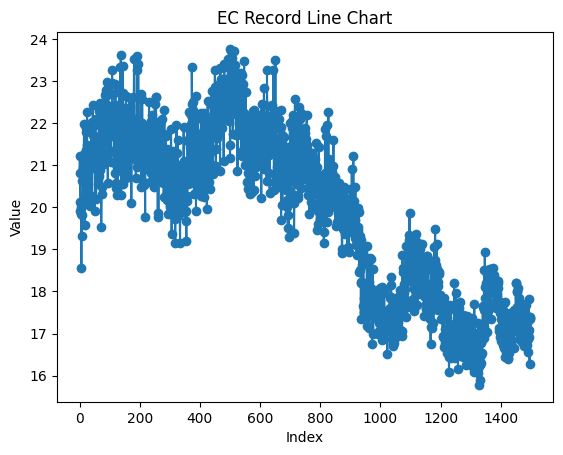

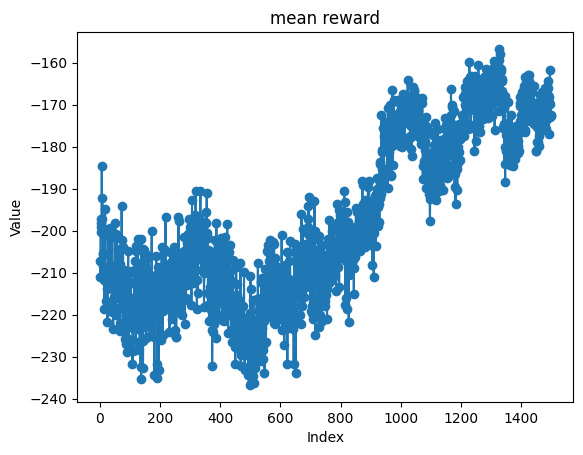

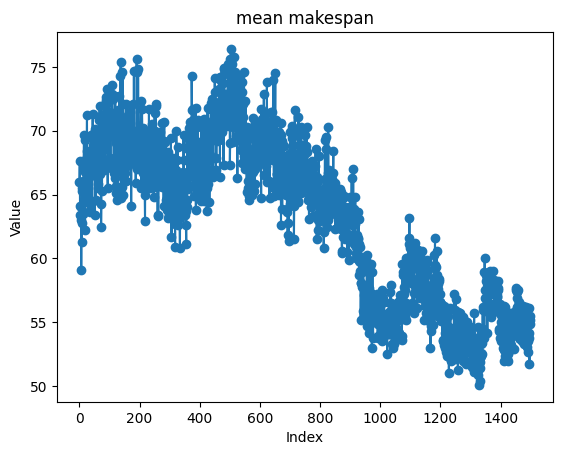

In [13]:
configs = parser.parse_args(args=[
    "--logdir", "./runs/model_test/main_model",
    "--model_suffix", "free",
    "--max_updates", "1500",
    "--n_j", "10",
    "--n_m", "5",
    "--num_envs", "10",
    '--high', '10'
    ])

trainer = DANTrainer(configs)

trainer.train()


In [8]:
def schedule_fjsp(problem):
    num_jobs = 6
    num_machines = 2
    schedule = [[0]*num_machines for _ in range(num_jobs)]

    # 计算每个工件每个工序的开始时间
    for job in problem:
        machine_1_time = 0
        machine_2_time = 0
        for i in range(num_jobs):
            machine_1_time += job[i][0]
            machine_2_time = max(machine_1_time, machine_2_time) + job[i][1]
            schedule[i] = [machine_1_time - job[i][0], machine_2_time - job[i][1]]

    return schedule

def calculate_energy(schedule, idle_energy=0.2, working_energy=1):
    total_energy = 0
    
    # 遍历每个工件的排程
    for job_schedule in schedule:
        # 遍历每个工序
        for machine, start_time in enumerate(job_schedule):
            # 如果工序开始时间为0，则不消耗能量
            if start_time == 0:
                continue
            # 否则，工作机器消耗能量
            total_energy += working_energy
    
    # 计算机器空闲能量消耗
    total_energy += idle_energy * len(schedule[0]) * len(schedule)
    
    return total_energy

# 定义问题数据
problems = [
    [[0, 84], [58, 87], [98, 0], [0, 74], [33, 0], [97, 0]],
    [[85, 0], [67, 0], [48, 62], [49, 8], [93, 53], [0, 86]]
]

# 对每个FJSP问题进行排程和能量计算
for idx, problem in enumerate(problems):
    schedule = schedule_fjsp(problem)
    energy_consumption = calculate_energy(schedule)
    print(f"FJSP问题 {idx+1} 的能量消耗为: {energy_consumption}")


TypeError: 'int' object is not subscriptable

-------------------------Training Setting-------------------------
source : SD2
model name :../trained_network/SD2/10x5+mix.pth
vali data :./data/data_train_vali/SD2/10x5+mix


progress:   0%|          | 0/21 [00:00<?, ?it/s][[ 0  0 71 27 81]
 [ 7 15 76 55 72]
 [ 0 44  0 56 26]
 [ 0 85  0  0 13]
 [19 82  0 52 45]
 [ 0 57 92 50  0]
 [ 4  0 12 22 90]
 [ 0  0 12  0 95]
 [ 0  0 88 15  0]
 [ 0 13  0  0  0]
 [ 0 62  0  0 48]
 [ 0  0 87 47  0]
 [ 0  0 26  0  0]
 [ 1  0  0  0  0]
 [69  0  0  0 61]
 [66 77 68 45  0]
 [ 8 89 71 14 29]
 [64  0  0  0  0]
 [ 0  0 59  0  0]
 [79  7 66 95 71]
 [ 0  0 77 77  0]
 [ 0 14 45  2 42]
 [79  0 88 64  0]
 [ 4 18 89 88 70]
 [98  0  3 19  0]
 [46 58 36 19 92]
 [47  0  0  0  0]
 [ 0  0 27  0  0]
 [11  0  0 59  0]
 [ 0 26 28 58  4]
 [79 86 60 49 57]
 [88 88  5 70 57]
 [61 10 67 34 70]
 [ 0 80 29  0  0]
 [ 4 49  4  0 92]
 [56  0  0 50 88]
 [86  0  0  0 67]
 [46 11  9 97 26]
 [ 0  0  0 71  0]
 [40  0 93 39  6]
 [10 41  0  0 22]
 [ 0  0  0 45  0]
 [ 0 82 62 15 79]
 

In [ ]:
np.array([[[48, 74, 33],
        [47, 97,  0],
        [84, 79, 37],
        [97, 81, 69],
        [ 0,  0, 68],
        [ 3, 85, 40],
        [67, 85, 48],
        [ 0, 49,  8],
        [93, 53, 98],
        [86,  0, 28],
        [35, 98, 77],
        [41,  0, 70],
        [65,  0,  0],
        [ 0, 11, 23],
        [78, 19, 16]],

       [[49,  0, 92],
        [50, 87,  4],
        [68, 12,  0],
        [90, 99,  0],
        [12,  4, 95],
        [ 7,  0,  0],
        [15,  0,  0],
        [13, 55,  0],
        [ 0,  0, 62],
        [75, 66, 48],
        [ 0,  6, 87],
        [47,  0, 60],
        [41,  0,  0],
        [50,  0, 36],
        [30,  2,  0]]])